**Note:** This notebook was developed as part of the CIFO project. I've built each step iteratively to make sure I understood how genetic algorithms can be applied to real-world group optimization problems.

In this notebook, I will develop a Genetic Algorithm to optimize the seating
arrangement for a wedding with 64 guests divided across 8 tables.

The objective is to maximize overall guest happiness, based on their pairwise
relationship scores, while ensuring that each guest is assigned to exactly one table.

# Wedding Seating Optimization
# CIFO 2024/2025 – Final Project

In [346]:
import pandas as pd
import numpy as np

## Load the pairwise relationship matrix

In [347]:
df = pd.read_csv("../data/seating_data.csv", index_col=0)

## Check basic properties

In [348]:
print("Matrix shape:", df.shape)
print("Unique relationship values:", np.unique(df.values))
df.head()

Matrix shape: (64, 64)
Unique relationship values: [-1000     0   100   300   400   500   700   900  1000  2000  5000]


,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
idx,,,,,,,,,,,,,,,,,,,,,
1,0,5000,0,0,700,700,0,0,0,0,...,100,100,0,0,100,100,100,0,0,0
2,5000,0,700,700,0,0,300,300,500,500,...,100,100,0,100,0,0,0,0,0,0
3,0,700,0,2000,0,0,0,0,300,300,...,0,0,0,0,0,0,0,0,0,0
4,0,700,2000,0,0,0,900,400,300,300,...,0,0,0,0,0,0,0,0,0,0
5,700,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


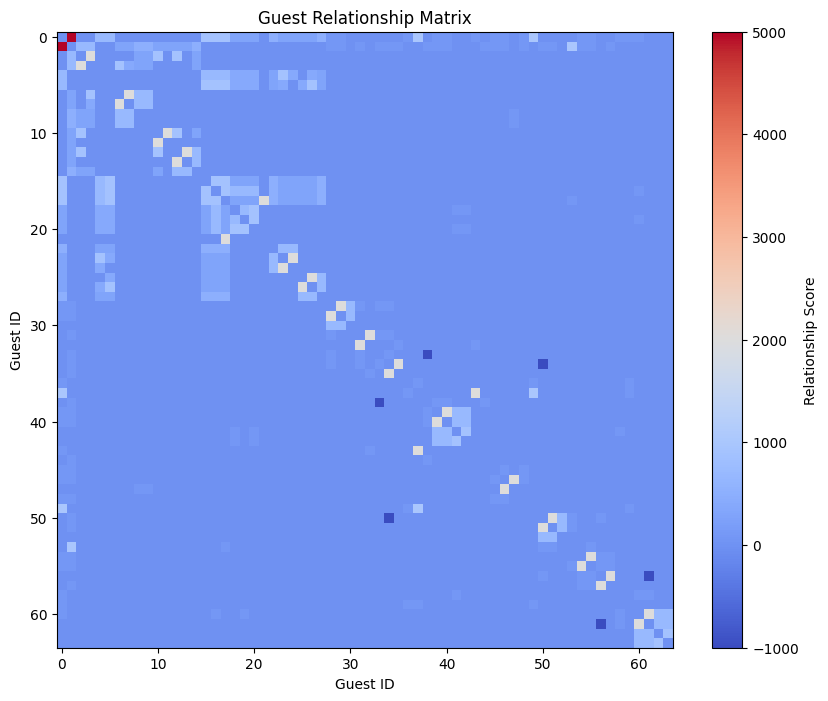

In [349]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(df.values, cmap="coolwarm", interpolation="nearest")
plt.title("Guest Relationship Matrix")
plt.colorbar(label="Relationship Score")
plt.xlabel("Guest ID")
plt.ylabel("Guest ID")
plt.show()

# INDIVIDUAL REPRESENTATION


## Example of a valid individual(random assignment)

In [350]:
# Each solution (individual) is represented as a list of 8 tables.
# Each table is a list of guest IDs (from 1 to 64), and each guest
# must appear exactly once in the entire individual.

In [351]:
import random

def generate_random_individual(num_guests=64, num_tables=8):
    guests = list(range(1, num_guests + 1))
    random.shuffle(guests)
    
    table_size = num_guests // num_tables
    return [guests[i*table_size:(i+1)*table_size] for i in range(num_tables)]

## Generate a sample individual

In [352]:
individual = generate_random_individual()
for i, table in enumerate(individual, start=1):
    print(f"Table {i}: {table}")

Table 1: [22, 1, 3, 57, 63, 50, 64, 34]
Table 2: [20, 13, 6, 45, 9, 31, 43, 40]
Table 3: [53, 30, 18, 62, 46, 42, 36, 4]
Table 4: [47, 48, 14, 49, 44, 5, 17, 59]
Table 5: [29, 51, 26, 24, 56, 16, 38, 41]
Table 6: [27, 39, 60, 35, 28, 54, 37, 12]
Table 7: [23, 25, 33, 10, 19, 7, 55, 15]
Table 8: [58, 11, 2, 32, 61, 21, 52, 8]


# FITNESS FUNCTION


In [353]:
from itertools import combinations

In [354]:
# Calculates how good a seating plan is by summing the relationship scores between every pair of guests sitting at the same table.

def compute_fitness(individual, relationship_matrix):
    total_score = 0

    for table in individual:
        pairs = combinations(table, 2)  # all unique guest pairs at the table
        for guest1, guest2 in pairs:
            score = relationship_matrix.loc[guest1, str(guest2)]
            total_score += score

    return total_score

In [355]:
individual = generate_random_individual()

score = compute_fitness(individual, df)
print("Total fitness score:", score)

Total fitness score: 10800


# MUTATION 1 – SWAP TWO GUESTS FROM DIFERENT TABLES

In [356]:
import copy

# Swaps one guest from each of two randomly chosen tables

def mutation_swap_guests(individual):
    mutated = copy.deepcopy(individual)

    table1_idx, table2_idx = random.sample(range(8), 2)
    table1 = mutated[table1_idx]
    table2 = mutated[table2_idx]

    guest1_idx = random.randint(0, 7)
    guest2_idx = random.randint(0, 7)

    table1[guest1_idx], table2[guest2_idx] = table2[guest2_idx], table1[guest1_idx]

    return mutated

In [357]:
original = generate_random_individual()
mutated = mutation_swap_guests(original)

print("Original (table 1):", original[0])
print("Mutated  (table 1):", mutated[0])

Original (table 1): [18, 33, 13, 36, 58, 27, 45, 14]
Mutated  (table 1): [18, 33, 13, 36, 5, 27, 45, 14]


# MUTATION 2 – MOVE GUEST TO A DIFFERENT TABLE

In [358]:
# Moves one guest from one table to another by swapping them

def mutation_move_guest(individual):
    mutated = copy.deepcopy(individual)

    from_table_idx, to_table_idx = random.sample(range(8), 2)
    from_table = mutated[from_table_idx]
    to_table = mutated[to_table_idx]

    guest_from_idx = random.randint(0, 7)
    guest_to_idx = random.randint(0, 7)

    from_guest = from_table[guest_from_idx]
    to_guest = to_table[guest_to_idx]

    from_table[guest_from_idx] = to_guest
    to_table[guest_to_idx] = from_guest

    return mutated



In [359]:
original = generate_random_individual()
mutated = mutation_move_guest(original)

print("Original (table 2):", original[1])
print("Mutated  (table 2):", mutated[1])


Original (table 2): [18, 2, 25, 4, 43, 31, 46, 56]
Mutated  (table 2): [18, 2, 25, 4, 43, 31, 46, 56]


# MUTATION 3 – SHUFFLE GUESTS INSIDE A TABLE

In [360]:
# Shuffle the order of guests within a randomly selected table.
# It doesn’t affect fitness directly but adds genetic diversity.

def mutation_shuffle_table(individual):
    mutated = copy.deepcopy(individual)
    table_idx = random.randint(0, 7)
    random.shuffle(mutated[table_idx])
    return mutated

In [361]:
original = generate_random_individual()
mutated = mutation_shuffle_table(original)

print("Original (table 6):", original[5])
print("Mutated  (table 6):", mutated[5])

Original (table 6): [1, 18, 25, 13, 4, 26, 21, 22]
Mutated  (table 6): [1, 18, 25, 13, 4, 26, 21, 22]


In [362]:
def print_guest_distribution(ind):
    all_guests = [guest for table in ind for guest in table]
    print("Guests present:", sorted(all_guests))
    print("Total guests:", len(all_guests), "| Unique:", len(set(all_guests)))

print("Original distribution:")
print_guest_distribution(original)

print("\nMutated distribution:")
print_guest_distribution(mutated)


Original distribution:
Guests present: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
Total guests: 64 | Unique: 64

Mutated distribution:
Guests present: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
Total guests: 64 | Unique: 64


# CROSSOVER 1 – TABLE-BASED CROSSOVER

In [363]:
# Builds a new individual by combining 4 tables from each parent

def crossover_tables_half_half(parent1, parent2):
    p1_guests = [guest for table in parent1 for guest in table]
    p2_guests = [guest for table in parent2 for guest in table]

    child_guests = set()
    p1_tables = random.sample(range(8), 4)
    p2_tables = [i for i in range(8) if i not in p1_tables]

    child_tables = []

    for i in p1_tables:
        child_tables.append(parent1[i])
        child_guests.update(parent1[i])

    for i in p2_tables:
        table = [g for g in parent2[i] if g not in child_guests]
        child_tables.append(table)
        child_guests.update(table)

    all_guests = set(range(1, 65))
    missing = list(all_guests - child_guests)

    for guest in missing:
        for table in child_tables:
            if len(table) < 8:
                table.append(guest)
                break

    return child_tables

In [364]:
p1 = generate_random_individual()
p2 = generate_random_individual()
child = crossover_tables_half_half(p1, p2)

print("Child table sizes:", [len(table) for table in child])
print_guest_distribution(child)


Child table sizes: [8, 8, 8, 8, 8, 8, 8, 8]
Guests present: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
Total guests: 64 | Unique: 64


In [365]:
print("Child table sizes:", [len(table) for table in child])
print_guest_distribution(child)

Child table sizes: [8, 8, 8, 8, 8, 8, 8, 8]
Guests present: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
Total guests: 64 | Unique: 64


# CROSSOVER 2 – GUEST-WISE CROSSOVER

In [366]:
# For each guest, randomly picks which parent to follow, then reconstructs a valid seating plan with 8 tables

def crossover_guest_level(parent1, parent2):
    guest_table_map = {}

    p1_map = {guest: i for i, table in enumerate(parent1) for guest in table}
    p2_map = {guest: i for i, table in enumerate(parent2) for guest in table}

    for guest in range(1, 65):
        if random.random() < 0.5:
            guest_table_map[guest] = p1_map[guest]
        else:
            guest_table_map[guest] = p2_map[guest]

    tables_raw = [[] for _ in range(8)]
    for guest, table_idx in guest_table_map.items():
        tables_raw[table_idx].append(guest)

    flat = [g for t in tables_raw for g in t]
    random.shuffle(flat)
    child = [flat[i*8:(i+1)*8] for i in range(8)]

    return child

In [367]:
p1 = generate_random_individual()
p2 = generate_random_individual()
child = crossover_guest_level(p1, p2)

print("Child table sizes:", [len(table) for table in child])
print_guest_distribution(child)


Child table sizes: [8, 8, 8, 8, 8, 8, 8, 8]
Guests present: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
Total guests: 64 | Unique: 64


# SELECTION 1 – TOURNAMENT SELECTION

In [368]:
# Chooses k individuals randomly and returns the best one

def tournament_selection(population, fitnesses, k=3):
    selected_indices = random.sample(range(len(population)), k)
    best_index = selected_indices[0]

    for idx in selected_indices:
        if fitnesses[idx] > fitnesses[best_index]:
            best_index = idx

    return copy.deepcopy(population[best_index])


# SELECTION 2 – ROULETTE WHEEL SELECTION

In [369]:
# Chooses one individual based on fitness-proportional probability

def roulette_selection(population, fitnesses):
    total_fitness = sum(fitnesses)

    if total_fitness == 0:
        probs = [1 / len(population)] * len(population)
    else:
        probs = [f / total_fitness for f in fitnesses]

    selected_index = random.choices(range(len(population)), weights=probs, k=1)[0]
    return copy.deepcopy(population[selected_index])

In [370]:
# Quick test to compare both selection methods

pop = [generate_random_individual() for _ in range(10)]
fit = [compute_fitness(ind, df) for ind in pop]

t_selected = tournament_selection(pop, fit)
print("Tournament selection result:", compute_fitness(t_selected, df))

r_selected = roulette_selection(pop, fit)
print("Roulette selection result:", compute_fitness(r_selected, df))

Tournament selection result: 15600
Roulette selection result: 15600


# GENETIC ALGORITHM – MAIN LOOP

In [371]:
def run_genetic_algorithm(
    population_size=50,
    generations=100,
    crossover_prob=0.8,
    mutation_prob=0.3,
    elitism=True
):
    population = [generate_random_individual() for _ in range(population_size)]
    fitnesses = [compute_fitness(ind, df) for ind in population]

    best_individual = copy.deepcopy(population[np.argmax(fitnesses)])
    best_fitness = max(fitnesses)
    history = [best_fitness]

    for gen in range(generations):
        new_population = []

        if elitism:
            new_population.append(copy.deepcopy(best_individual))

        while len(new_population) < population_size:
            parent1 = tournament_selection(population, fitnesses)
            parent2 = roulette_selection(population, fitnesses)

            if random.random() < crossover_prob:
                if random.random() < 0.5:
                    child = crossover_tables_half_half(parent1, parent2)
                else:
                    child = crossover_guest_level(parent1, parent2)
            else:
                child = copy.deepcopy(parent1)

            if random.random() < mutation_prob:
                mutation_type = random.choice([
                    mutation_swap_guests,
                    mutation_move_guest,
                    mutation_shuffle_table
                ])
                child = mutation_type(child)

            new_population.append(child)

        population = new_population
        fitnesses = [compute_fitness(ind, df) for ind in population]

        current_best_index = np.argmax(fitnesses)
        current_best_fitness = fitnesses[current_best_index]

        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_individual = copy.deepcopy(population[current_best_index])

        history.append(best_fitness)

        if gen % 10 == 0 or gen == generations - 1:
            print(f"Generation {gen}: Best fitness = {best_fitness}")

    return best_individual, history

In [372]:
# Run the algorithm and store results
best_solution, history = run_genetic_algorithm()

final_fitness = history[-1]
print("Final best fitness:", final_fitness)

Generation 0: Best fitness = 27600
Generation 10: Best fitness = 45200
Generation 20: Best fitness = 53900
Generation 30: Best fitness = 54000
Generation 40: Best fitness = 60400
Generation 50: Best fitness = 61200
Generation 60: Best fitness = 61200
Generation 70: Best fitness = 61200
Generation 80: Best fitness = 63900
Generation 90: Best fitness = 64800
Generation 99: Best fitness = 65800
Final best fitness: 65800


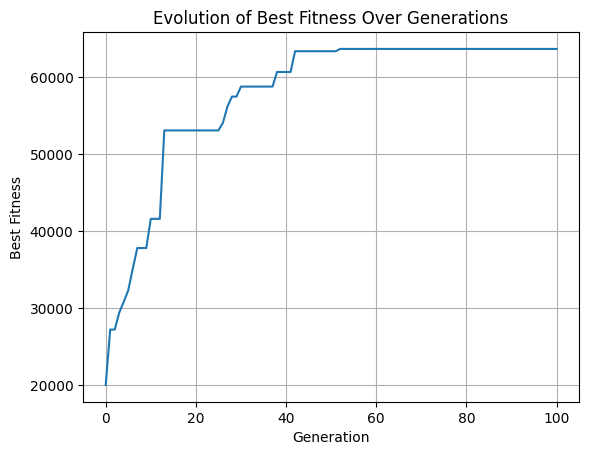

In [373]:
plt.plot(fitness_history)
plt.title("Evolution of Best Fitness Over Generations")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.grid(True)
plt.show()

In [374]:
import csv

def save_seating_plan(individual, filename="best_seating_plan.csv"):
    with open(f"../data/{filename}", mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Table", "Guest_IDs"])
        for i, table in enumerate(individual, start=1):
            writer.writerow([f"Table {i}"] + table)

save_seating_plan(best_solution)
print("Best seating plan saved to '../data/best_seating_plan.csv'")

Best seating plan saved to '../data/best_seating_plan.csv'
